# Prototyping

### Libraries

In [96]:
## Basic
from tqdm import tqdm_notebook as tqdm

# Computation
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np
import scipy

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Network Processing
import networkx as nx
from networkx.generators import random_graphs

## Loading and Preprocessing Network Data

### Loading Network Data

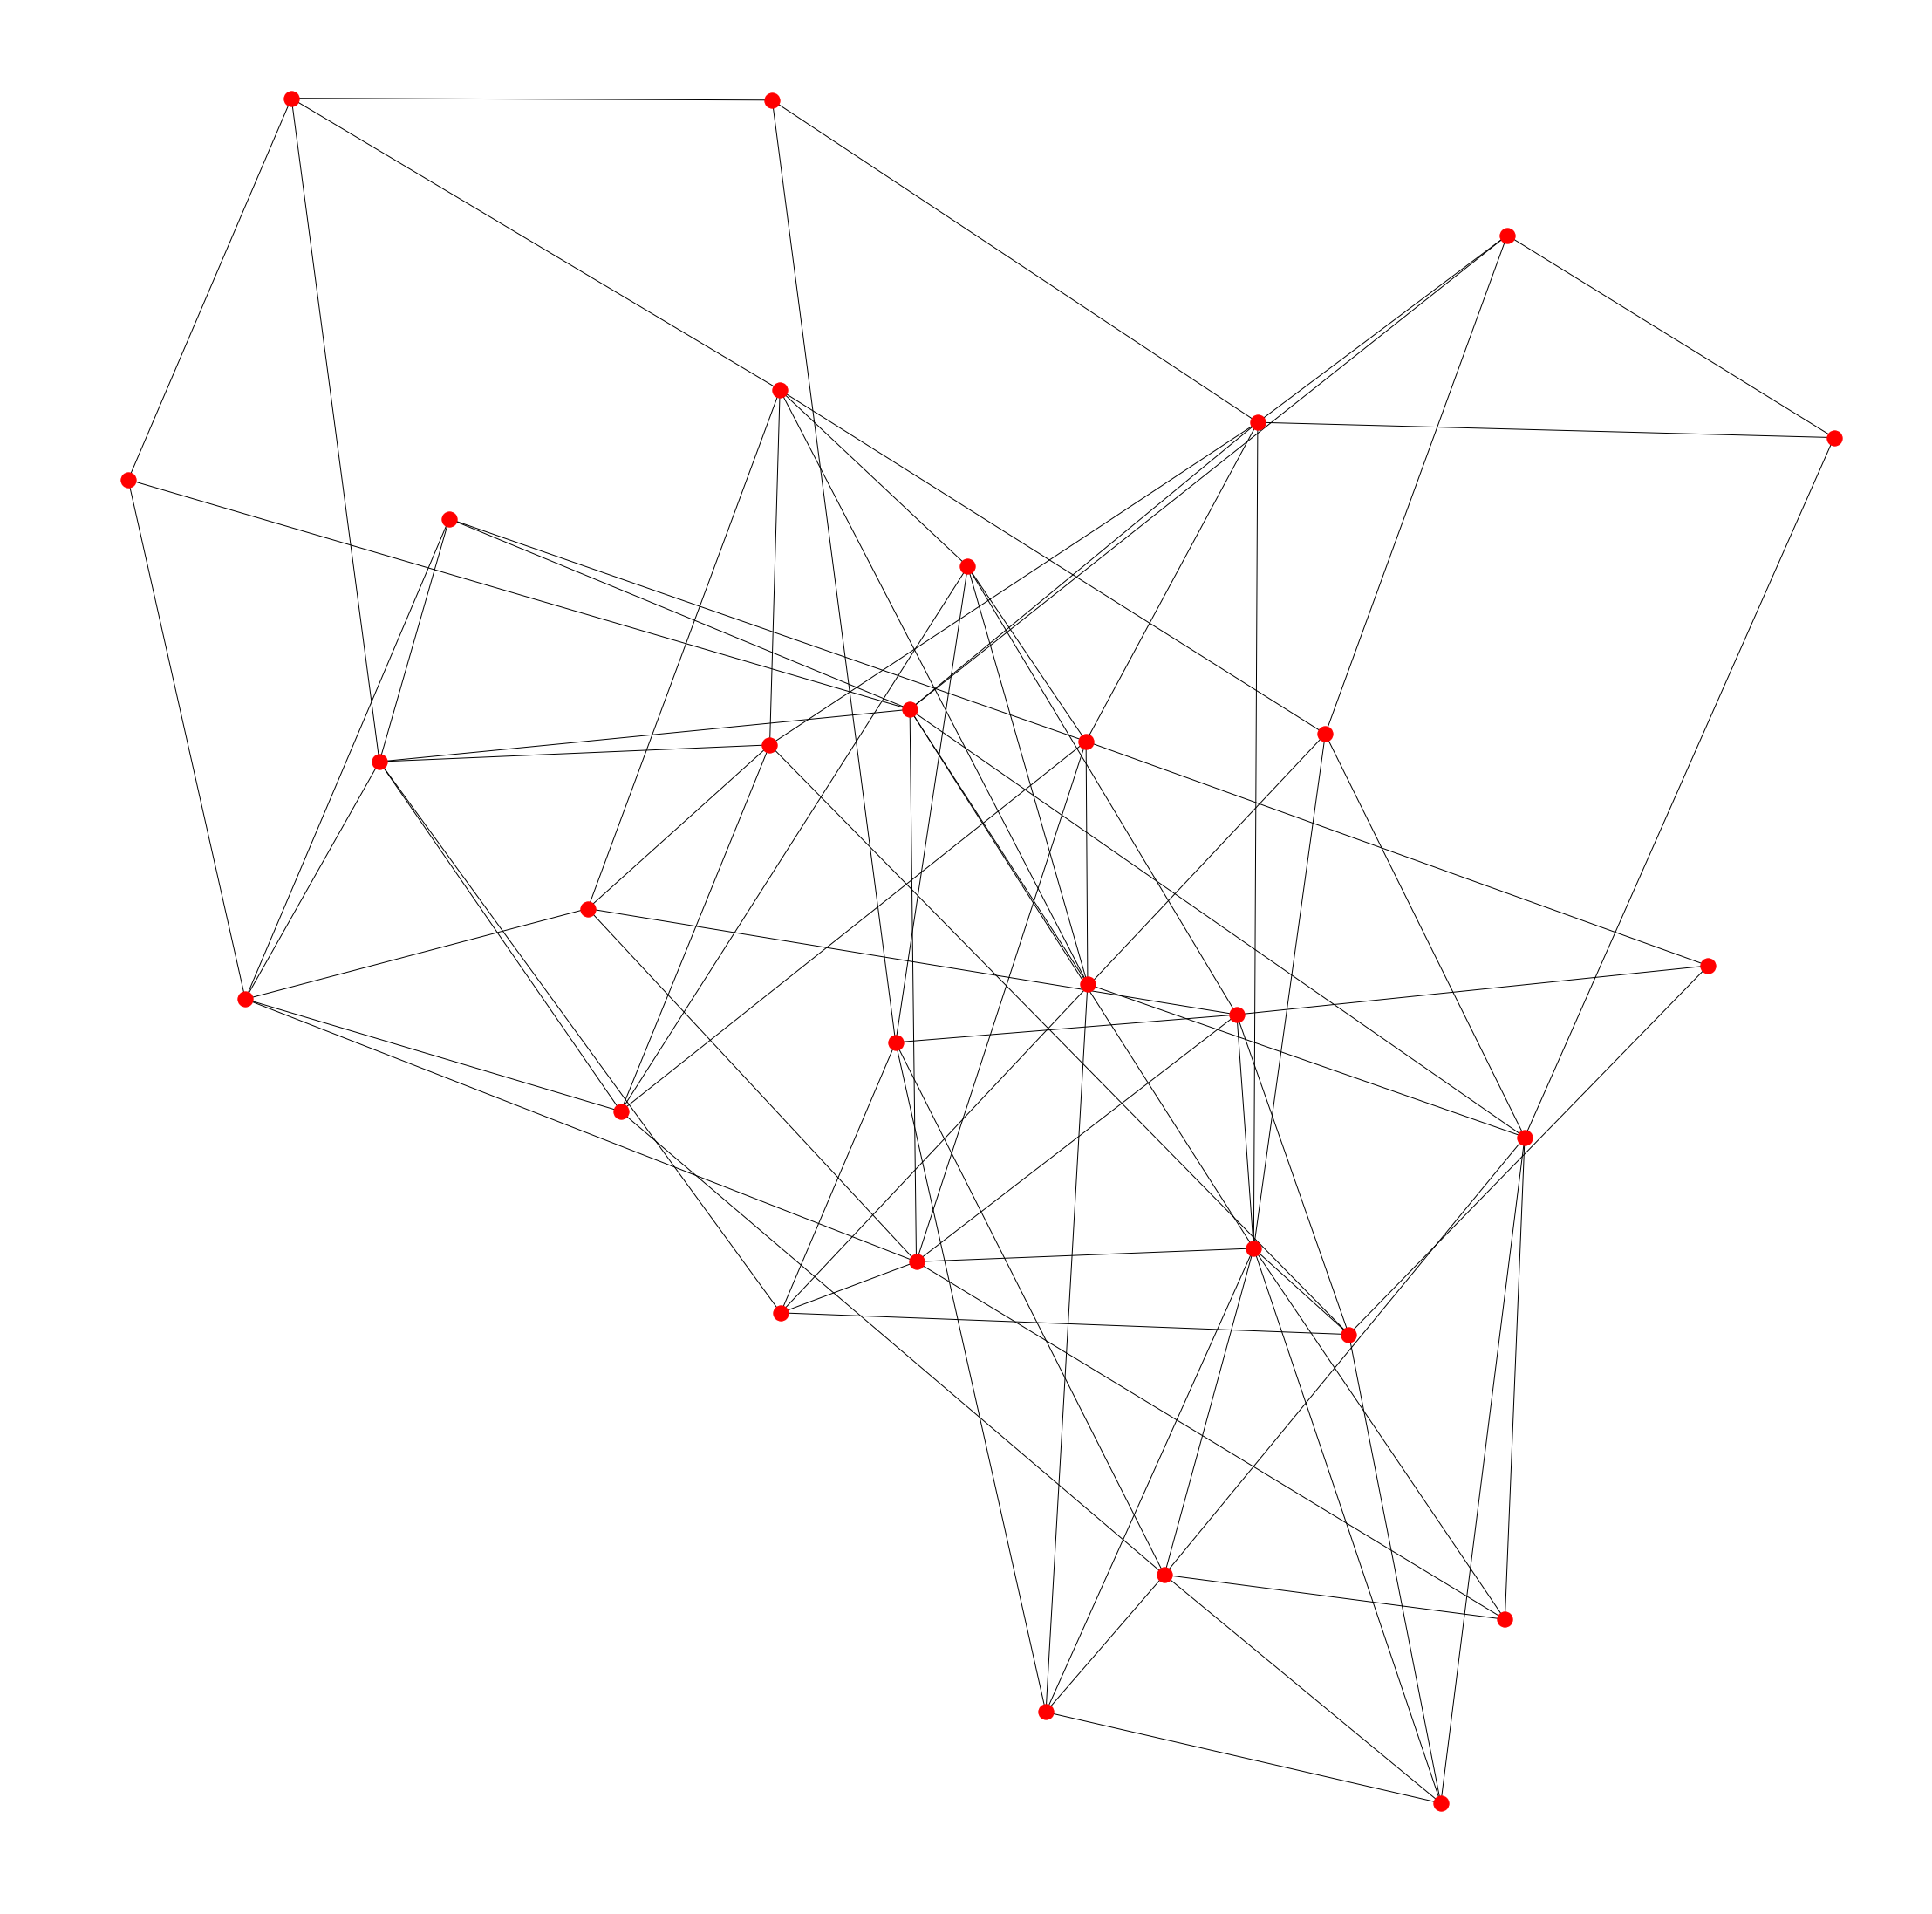

In [114]:
n = 30
p = 0.2

G = random_graphs.erdos_renyi_graph(n, p, seed=None, directed=False)
dh = nx.degree_histogram(G)
    
nx.draw(G)
plt.show()

### Preprocessing

In [118]:
## Sorting rows by node degree
def sort_adjacency(G):
    
    node_k = list(G.degree())
    node_k_ascending = sorted(node_k, key = lambda x: x[1])
        
    mapping = dict()
    for i, node in enumerate(node_k_ascending):
        
        mapping[node[0]] = i
            
    A = nx.adjacency_matrix(G, nodelist= mapping.keys()).todense()    
    G = nx.relabel_nodes(G, mapping)
    
    return G, A


def upper_triangle(A, node_features = None):
    
    ## append node_features to nodes
    upper_A = np.ravel(A[np.triu_indices(A.shape[0], k = 1)])
    
    return upper_A


def reconstruct_adjacency(upper_A):
    


G, A = sort_adjacency(G)
upper_A = upper_triangle(A)

print(upper_A.shape)
print("upper_A:\n\n",upper_A)

#nx.draw(G, with_labels=True)
#plt.show()

SyntaxError: invalid syntax (<ipython-input-118-c4adf6df0186>, line 25)

# Generating Training Data

In [82]:
n_graphs = 1000   # number of training instances
n = 30          # number of nodes


## Data ________________________________

upper_A_size = int(((n*n)/2)-(n/2))   # upper triangle of sorted adjacency matrix
G = np.zeros((n_graphs, upper_A_size))

## Ground Truth Labels ______________________________

T = list()



## Generate Graph Data_______________________________

for i in tqdm(range(0,n_graphs)):
    
    ## Generate Graph Type ______________________________________________
    
    p = np.random.rand(1)  # float in range 0 - 1 
    g = random_graphs.erdos_renyi_graph(n, p, seed=None, directed=False)
    
    g, a = sort_adjacency(g)
    upper_a = upper_triangle(a)
    
    
    ## Generate Ground Truth features____________________________________
    
    if nx.is_connected(g):
        diameter = nx.diameter(g)
    else:
        diameter = -1
    
    density = nx.density(g)
    
    ## toDO: add more graph topologies and figure out good data structure - dicts?
    
    
    ## Build Data Arrays___________________________________________________
    
    G[i] = upper_a
    T.append([p, diameter, density])


In [89]:
## Train and Validation Split _______________________________________________

T = np.asarray(T)
x_train, x_test, y_train, y_test = train_test_split(G, T, test_size=0.2, random_state=1, shuffle=True)

    

## Input and Output Size ___________________________________________________________

input_dim = x_train.shape[1]
print(x_train.shape)

(800, 435)


# VAE (most simple)

## Build Model

In [90]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


## MODEL ______________________________________________________________

# network parameters
modelArgs = {"input_shape": (input_dim, ), "intermediate_dim": 512, "latent_dim": 2}


# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=modelArgs["input_shape"], name='encoder_input')
x = Dense(modelArgs["intermediate_dim"], activation='relu')(inputs)
z_mean = Dense(modelArgs["latent_dim"], name='z_mean')(x)
z_log_var = Dense(modelArgs["latent_dim"], name='z_log_var')(x)



## Reparameterization Trick__________________________________________

# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(modelArgs["latent_dim"],), name='z')([z_mean, z_log_var])



## INSTANTIATE ________________________________________________

## 1) instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

## 2) build decoder model
latent_inputs = Input(shape=(modelArgs["latent_dim"],), name='z_sampling')
x = Dense(modelArgs["intermediate_dim"], activation='relu')(latent_inputs)
outputs = Dense(input_dim, activation='sigmoid')(x)

## 3) instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

## 4) instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_graph')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 435)          0                                            
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 512)          223232      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_25[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_25[0][0]                   
__________________________________________________________________________________________________
z (Lambda)

## Train Model

In [91]:
## Configs  

trainArgs = {"loss": "mse", "weights": "train", "batch_size": 128, "epochs": 50, "beta": 1.0}

models = (encoder, decoder)
data = (x_test, y_test)

# VAE loss = mse_loss or xent_loss + kl_loss

if trainArgs["loss"] == "mse":
    reconstruction_loss = mse(inputs, outputs)
if trainArgs["loss"] == "binary_crossentropy":
    reconstruction_loss = binary_crossentropy(inputs, outputs)


## LOSS _____________________________________________

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + (trainArgs["beta"] * kl_loss))
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
#plot_model(vae,to_file='vae_mlp.png',show_shapes=True)


## TRAIN______________________________________________

# load the autoencoder weights

if trainArgs["weights"] == "load":
    
    vae.load_weights("models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5")

# train the autoencoder

elif trainArgs["weights"] == "train":
    vae.fit(x_train, epochs=trainArgs["epochs"], batch_size=trainArgs["batch_size"], validation_data=(x_test, None))
    vae.save_weights("models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5")



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 435)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 225284    
_________________________________________________________________
decoder (Model)              (None, 435)               224691    
Total params: 449,975
Trainable params: 449,975
Non-trainable params: 0
_________________________________________________________________
Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 1s 705us/step - loss: 196.1288 - val_loss: 194.0909
Epoch 2/50
800/800 [==============================] - 0s 50us/step - loss: 191.9808 - val_loss: 184.5274
Epoch 3/50
800/800 [==============================] - 0s 52us/step - loss: 179.6534 - val_loss: 163.6395
Epoch 4/50
800/800 [==================

# Latent Space Analysis

# Encoder

## Iterate through single data dimension and oberseve single late space dimension  

## Visualize the Latent Space in 2D

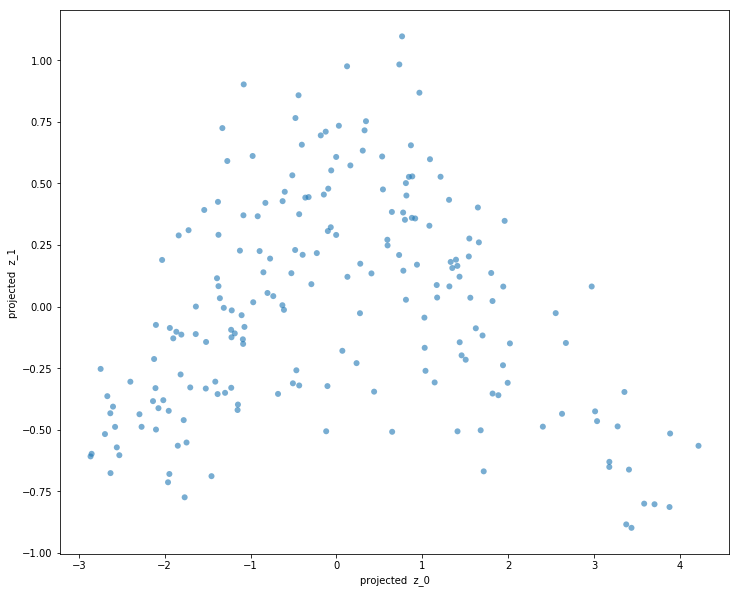

In [111]:
analyzeArgs = {"save_plots": False}


def analyze_latent_space(models,data,batch_size=128,model_name="vae_mnist"):
    
    """Plots labels and data as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models  # trained models
    x_test, y_test = data

    
    ## ENCODER - 2D Digit Classes _________________________________________
    
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test, batch_size = batch_size)
    
    
    ## DIMENSIONALITY REDUCTION _______________________
    
    pca = PCA(n_components=2)
    projected_z = pca.fit_transform(z_mean) 
    
    ## toDO: add t-SNE
    
    
    # Plot_____________________________
    
    #plt.figure(figsize=(12, 10))
    #plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    #plt.colorbar()
    #plt.xlabel("z[0]")
    #plt.ylabel("z[1]")
    #plt.show()
    
    plt.figure(figsize=(12, 10))
    #plt.scatter(projected_z[:, 0], projected_z[:, 1], c=y_test[:0], edgecolor='none', alpha=0.6)
    plt.scatter(projected_z[:, 0], projected_z[:, 1], edgecolor='none', alpha=0.6)
    plt.xlabel('projected  z_0')
    plt.ylabel('projected  z_1')
    #plt.colorbar()
    
    
    if analyzeArgs["save_plots"] == True:
            os.makedirs(model_name, exist_ok=True)
            filename = os.path.join(model_name, "vae_mean.png")
            plt.savefig(filename)
            

## PLOT RESULTS ________________________________________

analyze_latent_space(models, data, batch_size=trainArgs["batch_size"], model_name="vae_mlp")

## Visualize Latent Generative Distribution

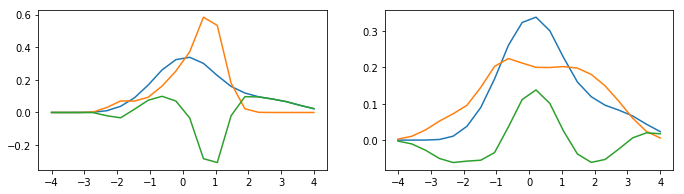

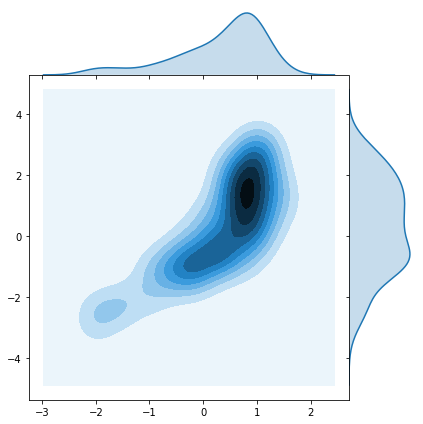

In [106]:
def visualize_latent_generative_dist(models,data,batch_size,model_name="vae_mnist"):

    encoder, decoder = models  # trained models
    x_test, y_test = data

    # display a 2D plot of the digit classes in the latent space
    z_mean, z_log_var, z = encoder.predict(x_test, batch_size)


    # Plot Distributions _________________________________

    #plt.figure(figsize=(12, 10))
    #plt.scatter(z_mean[:, 0], z_mean[:, 1])
    #plt.xlabel("z[0]")
    #plt.ylabel("z[1]")
    #plt.show()

    #sns.set_palette("PuBuGn_d")
    #normal = np.random.normal(0.0, 1.0, 1000)  # mean, std, data_points

    #for i in range(1, modelArgs["latent_dim"]+1):

        #plt.subplot(3, 5, i)
        #sns.distplot(z_mean[:,i-1]).set_title("z_"+str(i))
        #sns.distplot(normal)
                
        
        
    ## Plot Difference Plot _______________________________
    
    normal = np.random.gumbel(0.0, 1.0, z_mean[:,0].shape[0])
    kde_normal = scipy.stats.gaussian_kde(normal)


    for i in range(1, modelArgs["latent_dim"]+1):

        plt.subplot(3, 5, i)
        plt.rcParams['figure.figsize']=(30,30)

        grid = np.linspace(-4,4, 20)
        kde_z = scipy.stats.gaussian_kde(z_mean[:,i-1])

        plt.plot(grid, kde_normal(grid), label="kde_normal")
        plt.plot(grid, kde_z(grid), label="kde_z")
        plt.plot(grid, kde_normal(grid)-kde_z(grid), label="difference")

        #plt.legend()

        
    ## Plot Joint Distribution Plot _______________________________

    ## outline how much learned variables deviates from normal distribution
    g = sns.jointplot(z_mean[:,0], z_mean[:,1], kind="kde", space=0)

    
visualize_latent_generative_dist(models,data,trainArgs["batch_size"],model_name="vae_mnist")

# Decoder

## Interpolate Latent Space Dimensions - Correlation with Graph Topologies

## Generate a Single Graph Instance

In [112]:
## apply decoder and generate data

def generate_single_instance(models, data, batch_size=128, model_name="vae_mlp"):
    
    print("latent dimensions:", modelArgs["latent_dim"])
    
    z_sample = np.zeros(modelArgs["latent_dim"])
    z_sample = np.reshape(z_sample, (1, modelArgs["latent_dim"]))
    
    
    ## visualize joint latent space of latent variable v1 and v2
    v0 = 0
    v1 = 1
    
    ## activations
    a0 = -1
    a1 = 3
                
    z_sample[0][v0] = a0
    z_sample[0][v1] = a1
    
    x_decoded = decoder.predict(z_sample)
    #digit = x_decoded[0].reshape(28, 28)
    #plt.imshow(digit)


        
generate_single_instance(models, data, batch_size=trainArgs["batch_size"], model_name="vae_mlp")

latent dimensions: 2


## Generate Interpolated Manifold from Latent Space

latent dimensions: 14


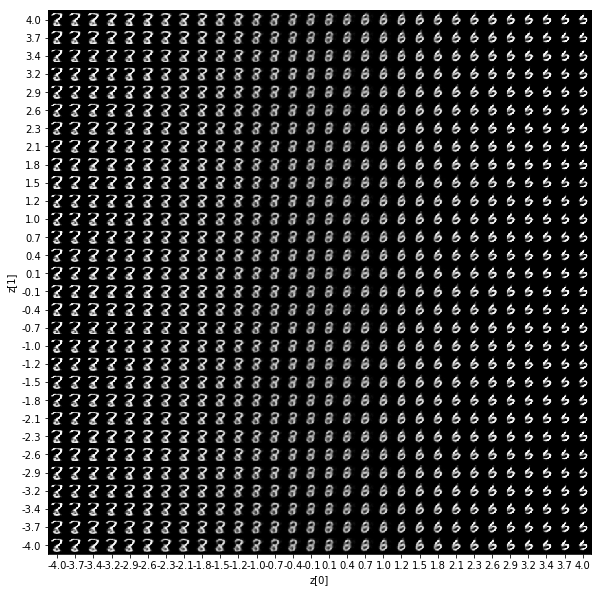

In [41]:
## DECODER - Latent Space Interpolation____________________________

def generate_interpolation_data(models, data, batch_size=128, model_name="vae_mlp"):
    
    print("latent dimensions:", modelArgs["latent_dim"])
    
    # display a 30x30 2D manifold of digits
    n = 30  # size of manifold
    digit_size = 28  # single figure size
    figure = np.zeros((digit_size * n, digit_size * n))

    
    ## Latent Space Dimension is 2 ______________________
    
    if modelArgs["latent_dim"] == 2:
            
        # linearly spaced coordinates corresponding to the 2D plot
        # of digit classes in the latent space
        grid_x = np.linspace(-4, 4, n)
        grid_y = np.linspace(-4, 4, n)[::-1] ## revert


        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z_sample = np.array([[xi, yi]])
                x_decoded = decoder.predict(z_sample)
                digit = x_decoded[0].reshape(digit_size, digit_size)
                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit

        start_range = digit_size // 2
        end_range = (n - 1) * digit_size + start_range + 1
        pixel_range = np.arange(start_range, end_range, digit_size)
        sample_range_x = np.round(grid_x, 1)
        sample_range_y = np.round(grid_y, 1)


        # Plot_____________________________

        plt.figure(figsize=(10, 10))
        plt.xticks(pixel_range, sample_range_x)
        plt.yticks(pixel_range, sample_range_y)
        plt.xlabel("z[0]")
        plt.ylabel("z[1]")
        plt.imshow(figure, cmap='Greys_r')
        plt.show()

        if analyzeArgs["save_plots"] == True:
            filename = os.path.join(model_name, "digits_over_latent.png")
            plt.savefig(filename) 
            
            
            
            
    ## Latent Space Dimension is larger than 2 ______________________
        
    if modelArgs["latent_dim"] > 2:
            
        # display a 30x30 2D manifold of digits
        n = 30  # size of manifold
        digit_size = 28  # single figure size
        figure = np.zeros((digit_size * n, digit_size * n))

        # linearly spaced coordinates corresponding to the 2D plot
        # of digit classes in the latent space
        grid_x = np.linspace(-4, 4, n)
        grid_y = np.linspace(-4, 4, n)[::-1]
        
        z_sample = np.zeros(modelArgs["latent_dim"])
        z_sample = np.reshape(z_sample, (1, modelArgs["latent_dim"]))
                
        ## visualize joint latent space of latent variable v1 and v2
        v0 = 0
        v1 = 1

        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                
                z_sample[0][v0] = xi
                z_sample[0][v1] = xi
                x_decoded = decoder.predict(z_sample)
                digit = x_decoded[0].reshape(digit_size, digit_size)
                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit

        start_range = digit_size // 2
        end_range = (n - 1) * digit_size + start_range + 1
        pixel_range = np.arange(start_range, end_range, digit_size)
        sample_range_x = np.round(grid_x, 1)
        sample_range_y = np.round(grid_y, 1)


        # Plot_____________________________

        plt.figure(figsize=(10, 10))
        plt.xticks(pixel_range, sample_range_x)
        plt.yticks(pixel_range, sample_range_y)
        plt.xlabel("z[0]")
        plt.ylabel("z[1]")
        plt.imshow(figure, cmap='Greys_r')
        plt.show()

        if analyzeArgs["save_plots"] == True:
            filename = os.path.join(model_name, "digits_over_latent.png")
            plt.savefig(filename) 

            
## Generate Data _______________________________________

generate_interpolation_data(models, data, batch_size=trainArgs["batch_size"], model_name="vae_mlp")

# To Do:

- add convolutions
- recurrent units 
...